- Grupo: Arthur Lira e Maria Eduarda Marques
- Base de Dados: https://www.kaggle.com/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/data

# Atividade em Grupo

## Considere para essa atividade o notebook Aula 04.

Vamos fazer uma análise de um dataset de sentimento, para isso, escolha um dataset qualquer, recomendo pegar um do Kaggle
https://www.kaggle.com/datasets?search=sentiment+analysis

Faça a análise dos dados e responda as perguntas:

1. Sobre o que são os dados?
2. Que tipo de limpeza de dados vocês fizeram?
3. Quais são os termos mais frequentes?
4. Qual o balanceamento dos dados?
5. Considere que vocês devem expandir essa base de dados
  - Quais as fontes de dados vocês podem usar?
  - Descreva como vocês iriam coletar esses dados?

# Desafio em grupo

Implemente um modelo de classificação a escolha do grupo.




# 1. Sobre o que são os dados?

Utilizamos o conjunto de dados "IMDB Movie Ratings Sentiment Analysis", que contém informações sobre análises de filmes, incluindo avaliações de usuários e análises de sentimentos (0 para negativo e 1 para positivo).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import re
import nltk
import string
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
urls = [
    "https://raw.githubusercontent.com/meduardamoliveira/cesar/main/movie_divide_csv_1.csv",
    "https://raw.githubusercontent.com/meduardamoliveira/cesar/main/movie_divide_csv_2.csv",
    "https://raw.githubusercontent.com/meduardamoliveira/cesar/main/movie_divide_csv_3.csv"
]

data_frames = [pd.read_csv(url) for url in urls]
df = pd.concat(data_frames)

In [ ]:
df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
9995,"""Western Union"" is something of a forgotten cl...",1
9996,This movie is an incredible piece of work. It ...,1
9997,My wife and I watched this movie because we pl...,0
9998,"When I first watched Flatliners, I was amazed....",1


In [ ]:
print(df.isnull().sum())

text     0
label    0
dtype: int64


In [ ]:
df['label'].value_counts()

0    20019
1    19981
Name: label, dtype: int64

# 2. Que tipo de limpeza de dados vocês fizeram?

Inicialmente rodamos uma linha de código pra remover valores ausente, então partimos para a normalização de texto (convertendo todo o texto para minúsculas e removendo caracteres especiais). Após isso removemos espaços extras, fizemos a tokenização e remoção de stopwords para facilitar e não distocer a análise.
Por fim, foi realizado o processo de lematização, facilitando a precisão da nossa análise.

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
# Remoção de valores ausentes
df.dropna(inplace=True)

# Normalização de texto
df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.replace('[^\w\s]', '')

# Remoção de espaços extras
df['text'] = df['text'].str.strip()

# Tokenização e remoção de stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

# Lemmatização
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

<ipython-input-8-15c6cd3caae4>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['text'] = df['text'].str.replace('[^\w\s]', '')
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# 3. Quais são os termos mais frequentes?

Os termos mais frequentes são: br, movie, film, one, like, time, good, character, even, get.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
all_reviews = ' '.join(df['text'])

# Tokenização
tokens = word_tokenize(all_reviews)

# Distribuição de frequência
freq_dist = FreqDist(tokens)

# Termos mais comuns
most_common_terms = freq_dist.most_common(10)  # Você pode ajustar o número conforme necessário

df_terms = pd.DataFrame(most_common_terms, columns=['term', 'frequency'])

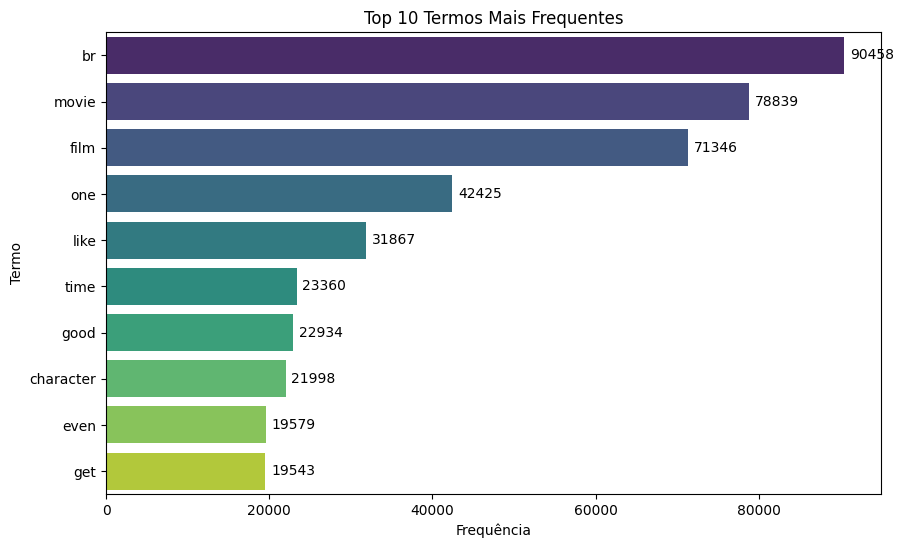

In [ ]:
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='frequency', y='term', data=df_terms, palette='viridis')
plt.xlabel('Frequência')
plt.ylabel('Termo')
plt.title('Top 10 Termos Mais Frequentes')

for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2.),
                     ha = 'center', va = 'center',
                     xytext = (20, 0),
                     textcoords = 'offset points')

plt.show()

# 4. Qual o balanceamento dos dados?

O conjunto de dados de avaliações do IMDB apresenta um bom exemplo de balanceamento entre classes. Com 19.908 avaliações classificadas como positivas (label '1') e 19.815 classificadas como negativas (label '0'), as proporções estão quase que empatadas, com cerca de 50,12% dos dados sendo positivos e 49,88% negativos.

In [ ]:
balanceamento = df['label'].value_counts()
proporcoes = balanceamento / len(df) * 100

print("Contagem de Labels:")
print(balanceamento)
print("\nProporções de Labels (%):")
print(proporcoes)

Contagem de Labels:
1    19908
0    19815
Name: label, dtype: int64

Proporções de Labels (%):
1    50.117061
0    49.882939
Name: label, dtype: float64


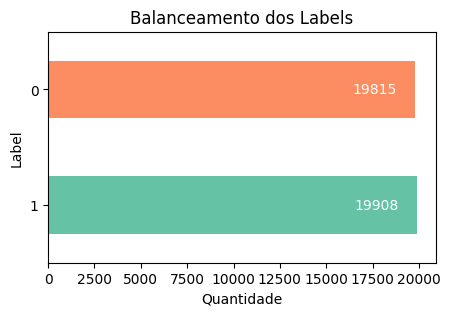

In [ ]:
plt.figure(figsize=(5, 3))
cores = sns.color_palette('Set2')
barplot = balanceamento.plot(kind='barh', color=cores[:2])
for p in barplot.patches:
    plt.text(p.get_width() - (p.get_width() * 0.05), p.get_y() + p.get_height() / 2,
             f'{int(p.get_width())}',
             va='center', ha='right', color='white')
plt.xlabel('Quantidade')
plt.ylabel('Label')
plt.title('Balanceamento dos Labels')
plt.show()

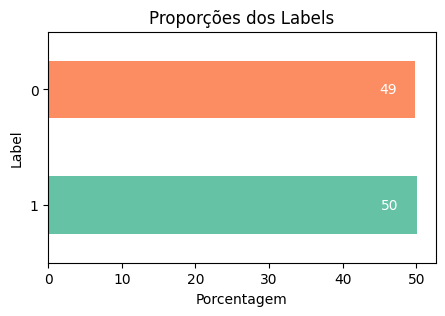

In [ ]:
plt.figure(figsize=(5, 3))
cores = sns.color_palette('Set2')
barplot = proporcoes.plot(kind='barh', color=cores[:2])
for p in barplot.patches:
    plt.text(p.get_width() - (p.get_width() * 0.05), p.get_y() + p.get_height() / 2,
             f'{int(p.get_width())}',
             va='center', ha='right', color='white')
plt.xlabel('Porcentagem')
plt.ylabel('Label')
plt.title('Proporções dos Labels')
plt.show()

# 5. Considere que vocês devem expandir essa base de dados
Quais as fontes de dados vocês podem usar?
Descreva como vocês iriam coletar esses dados?

Para expandir a base de dados, poderiamos utilizar fontes como outros sites de avaliações (Rotten Tomatoes, Metacritic), redes sociais (Twitter, Facebook) e fóruns (Reddit). Nesses três últimos seria interessante pegar a partir da hashtag de algum filme ou série em específico. A coleta pode ser feita através de APIs oficiais, web scraping ou até mesmo por meio de parcerias com plataformas de avaliação. Além disso, em relação ao próprio IMDB, seria interessante saber o nome e gênero de cada filme.

É essencial considerar aspectos éticos e legais, respeitando a privacidade dos usuários, os termos de serviço dos sites e as leis de direitos autorais. Para a coleta automatizada, scripts em Python podem ser programados para realizar scraping ou acessar APIs periodicamente, armazenando os dados coletados para análises futuras. Essas ações visam melhorar a diversidade e a quantidade de dados para treinar modelos de machine learning mais robustos e precisos.

# 6. Modelo de Classificação

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

MultinomialNB()

In [ ]:
y_pred = nb_classifier.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8597860289490246

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      3991
           1       0.87      0.85      0.86      3954

    accuracy                           0.86      7945
   macro avg       0.86      0.86      0.86      7945
weighted avg       0.86      0.86      0.86      7945



Utilizamos o modelo de classificação "Naive Bayes" para analisar sentimentos em avaliações de filmes, alcançando uma precisão geral de aproximadamente 85.98%. Outras medidas também foram aplicadas:

- **Avaliação Negativa (0)**:
   - **Precisão**: 85% (Quando o modelo prevê a classe negativa, ele está correto 85% das vezes).
   - **Recall**: 87% (O modelo identifica corretamente 87% de todas as instâncias negativas).
   - **F1-Score**: 86% (Uma média harmônica entre precisão e recall, indicando um equilíbrio entre essas métricas).

- **Avaliação Positiva (1)**:
   - **Precisão**: 87% (Quando o modelo prevê a classe positiva, ele está correto 87% das vezes).
   - **Recall**: 85% (O modelo identifica corretamente 85% de todas as instâncias positivas).
   - **F1-Score**: 86% (Similarmente, indica um bom equilíbrio entre precisão e recall).

As avaliações negativas e positivas estão bem distribuído, indicando que o conjunto de teste tem uma quantidade quase igual de exemplos de cada classe, o que é bom para avaliar o desempenho do modelo de forma equilibrada.

De modo geral, modelo demonstra uma boa performance, mas seria possível realizar alguns ajustes, como implementar técnicas adicionais de processamento de texto para aumentar ainda mais a precisão e outras métricas relevantes.